In [18]:
import scipy as sp
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.optimize import minimize

In [2]:
sp.__version__

'1.11.1'

In [3]:
def map_angles_to_n_sphere(angles, radius=1.0):
    # Convert angles to Cartesian coordinates on an n-sphere
    n = len(angles) +1  # Dimension of the n-sphere
    cartesian_coords = np.zeros(n) + radius
    cartesian_coords[0] = cartesian_coords[0]*np.cos(angles[0])
    for i in range(1,n-1):
        cartesian_coords[i] = cartesian_coords[i]*np.cos(angles[i])
        for j in range(i):
            cartesian_coords[i] = cartesian_coords[i]*np.sin(angles[j])
    for j in range(n-1):
        cartesian_coords[n-1] = cartesian_coords[n-1]*np.sin(angles[j])

    return cartesian_coords

In [4]:
vecs =[]
for i in np.linspace(0,np.pi/4, 10):
    for j in np.linspace(0,np.pi,10):
        vecs.append(map_angles_to_n_sphere([i,j], radius=1.0))

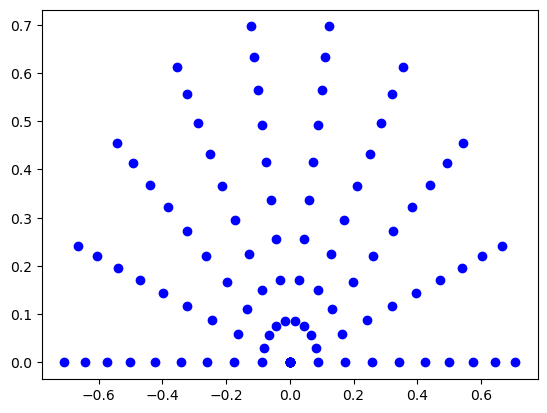

In [5]:
for vec in vecs:
    plt.scatter(vec[1],vec[2],color = 'b')

In [4]:
g = [1,0,0,0]
s = [-1,0,0,0]

np.matmul(g,np.matmul(np.linalg.inv(Jx),s))
np.linalg.inv(Jx - np.outer(g, s))

NameError: name 'Jx' is not defined

In [6]:
def dx_norm(df,g,s, Jx):
    if np.matmul(g,np.matmul(np.linalg.inv(Jx),s)) == 1:
        return 100000
    else:
        return np.linalg.norm(np.matmul(np.linalg.inv(Jx - np.outer(g, s)), df))

In [7]:
def dx_norm_efficient(df,Jxgs_inv,gJxs):
    if gJxs == 1:
        return 100000
    else:
        return np.linalg.norm(np.matmul(Jxgs_inv, df))

In [8]:
import numpy as np
from scipy import integrate
from scipy.special import iv

In [9]:
def von_mises_fisher_pdf(x, kappa, mu):
    return np.exp(kappa * np.dot(mu, x)) / ((2 * np.pi) ** (len(x)/2) * iv(len(x)/2 - 1, kappa))

def integrate_function_over_vmf(df,g,s, Jx, kappa):
    Jxgs_inv = np.linalg.inv(Jx - np.outer(g, s))
    gJxs = np.matmul(g,np.matmul(np.linalg.inv(Jx),s))
    def integrand(*args):
        x = np.array(args)
        return dx_norm_efficient(x,Jxgs_inv,gJxs) * von_mises_fisher_pdf(x, kappa, df)
    
    limits = [(0, 2*np.pi)] + [(0, np.pi) for _ in range(len(df) - 1)]  # Azimuthal angle and polar angles
    
    result, _ = integrate.nquad(integrand, ranges=limits)
    
    return result



In [234]:
df = [1,1]/np.linalg.norm([1,1])
kappa = 0.01
g = df
s = df
integrate_function_over_vmf(df,g,s, Jx, kappa)

4.512297803294921

In [10]:
def generate_evenly_distributed_vectors(n,k):
    vectors = []
    for i in range(k):
        angles = [np.random.rand()*2*np.pi for j in range(n-1)]
        vector = map_angles_to_n_sphere(angles)
        vectors.append(vector)
    return vectors

In [11]:
def generate_distributed_vectors(n,k,sigma):
    vectors = []
    mu = np.zeros(n) + 1
    mu = mu/np.linalg.norm(mu)
    vectors = sp.stats.vonmises_fisher.rvs(mu=mu, kappa = sigma,size = k)
    return vectors

In [19]:
def generate_distributed_vectors(mu,k,sigma):
    vectors = []
    vectors = sp.stats.vonmises_fisher.rvs(mu=mu, kappa = sigma,size = k)
    return vectors

In [12]:
vecs = generate_distributed_vectors(5,2000,200)
vecs.shape

(2000, 5)

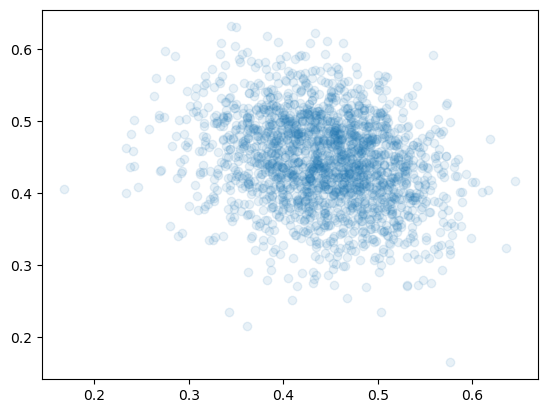

In [13]:
plt.scatter(vecs[:,0],vecs[:,3],alpha = .1)

In [89]:
n = 5

sigma = 0.01
v_1 = np.zeros(n)
v_1[0] = 1
df = np.zeros(n) + 1
df = df/np.linalg.norm(df)
theta = np.arccos(np.dot(df,v_1))
alphas_s = np.linspace(0,theta,100)
alphas_g = np.linspace(0,theta,100)
Jx = np.zeros((n,n))
for i in range(n):
    Jx[i,i] = -2
Jx[0,0]= -2
results = np.zeros((len(alphas_s),len(alphas_g)))
dfs = generate_distributed_vectors(n,2000,sigma)

for i in tqdm(range(len(alphas_s))):
    for j in range(len(alphas_g)):
        s = np.cos(alphas_s[i])*v_1 + np.cos(theta-alphas_s[i])*df
        g = np.cos(alphas_g[j])*v_1 + np.cos(theta-alphas_g[j])*df
        gJxs = np.matmul(g,np.matmul(np.linalg.inv(Jx),s))
        Jxgs_inv = np.linalg.inv(Jx - np.outer(g, s))
        results[i,j] = dx_norm_efficient(df,Jxgs_inv,gJxs)
        #results[i,j] = np.mean([dx_norm_efficient(df,Jxgs_inv,gJxs) for df in dfs])
    

100%|███████████████████████| 100/100 [00:01<00:00, 88.05it/s]


In [143]:
def optimize_nd_single_perturbation(n=5, mode_gap = 1, df = 0):
    if df == 0:
        df = (np.zeros(n) + 1)/np.linalg.norm(np.zeros(n) + 1)
    v_1 = np.zeros(n)
    v_1[0] = 1
    df_orth = np.array(df)
    df_orth[0] = 0
    df_orth = df_orth/np.linalg.norm(df_orth)
    theta = np.arccos(np.dot(df,v_1))
    alphas_s = np.linspace(0,theta,100)
    alphas_g = np.linspace(0,theta,100)
    Jx = np.zeros((n,n))
    for i in range(n):
        Jx[i,i] = -2
    Jx[0,0]= -2/mode_gap
    results = np.zeros((len(alphas_s),len(alphas_g)))    
    for i in range(len(alphas_s)):
        for j in range(len(alphas_g)):
            s = np.cos(alphas_s[i])*v_1 + np.sin(alphas_s[i])*df_orth
            g = np.cos(alphas_g[j])*v_1 + np.sin(alphas_g[j])*df_orth
            gJxs = np.matmul(g,np.matmul(np.linalg.inv(Jx),s))
            Jxgs_inv = np.linalg.inv(Jx - np.outer(g, s))
            results[i,j] = dx_norm_efficient(df,Jxgs_inv,gJxs)
    i,j = np.argwhere(results == np.min(results))[0]
    return theta, alphas_s[i], alphas_g[j]

In [14]:
def optimize_nd_many_perturbations(n=5, mode_gap = 1, sigma = 0.1, n_perturbs = 2000,df = 0):
    if df == 0:
        df = (np.zeros(n) + 1)/np.linalg.norm(np.zeros(n) + 1)
    v_1 = np.zeros(n)
    v_1[0] = 1
    df_orth = np.array(df)
    df_orth[0] = 0
    df_orth = df_orth/np.linalg.norm(df_orth)
    theta = np.arccos(np.dot(df,v_1))
    alphas_s = np.linspace(0,theta,100)
    alphas_g = np.linspace(0,theta,100)
    Jx = np.zeros((n,n))
    for i in range(n):
        Jx[i,i] = -2
    Jx[0,0]= -2/mode_gap
    results = np.zeros((len(alphas_s),len(alphas_g)))    
    dfs = generate_distributed_vectors(n,n_perturbs,sigma)

    for i in tqdm(range(len(alphas_s))):
        for j in range(len(alphas_g)):
            s = np.cos(alphas_s[i])*v_1 + np.sin(alphas_s[i])*df_orth
            g = np.cos(alphas_g[j])*v_1 + np.sin(alphas_g[j])*df_orth
            gJxs = np.matmul(g,np.matmul(np.linalg.inv(Jx),s))
            Jxgs_inv = np.linalg.inv(Jx - np.outer(g, s))
            results[i,j] = np.mean([dx_norm_efficient(df,Jxgs_inv,gJxs) for df in dfs])
    i,j = np.argwhere(results == np.min(results))[0]
    return theta, alphas_s[i], alphas_g[j]

In [23]:
def func_to_optimize(vars, df_orth, dfs, Jx):
    alpha_s, alpha_g = vars
    n = len(df)
    v_1 = np.zeros(n)
    v_1[0] = 1
    s = np.cos(alpha_s)*v_1 + np.sin(alpha_s)*df_orth
    g = np.cos(alpha_g)*v_1 + np.sin(alpha_g)*df_orth
    gJxs = np.matmul(g,np.matmul(np.linalg.inv(Jx),s))
    Jxgs_inv = np.linalg.inv(Jx - np.outer(g, s))
    return np.mean([dx_norm_efficient(dfp,Jxgs_inv,gJxs) for dfp in dfs])

In [61]:
n = 5
mode_gap = 100
Jx = np.zeros((n,n))
for i in range(n):
    Jx[i,i] = -2
Jx[0,0]= -2/mode_gap
df = (np.zeros(n) + 1)/np.linalg.norm(np.zeros(n) + 1)
n_perturbs = 2000
sigma = 0.1

v_1 = np.zeros(n)
v_1[0] = 1
df_orth = np.array(df)
df_orth[0] = 0
df_orth = df_orth/np.linalg.norm(df_orth)
theta = np.arccos(np.dot(df,v_1))

initial_guess = [theta/2, theta/2]  

s_bounds = (0, theta)  
g_bounds = (0, theta)  
# Create a bounds tuple for optimization
bounds = [s_bounds, g_bounds]

mode_gaps = np.logspace(0,2.5,60)
sigmas = [0.01,1,5,10,20]
alphas_s = np.zeros((len(mode_gaps),len(sigmas)))
alphas_g = np.zeros((len(mode_gaps),len(sigmas)))

for j in tqdm(range(len(sigmas))):
    dfs = generate_distributed_vectors(df,n_perturbs,sigmas[j])
    for i in range(len(mode_gaps)):
        Jx[0,0]= -2/mode_gaps[i]
        # Call the minimize function to optimize the function while keeping other variables fixed
        result = minimize(func_to_optimize, initial_guess, args=(df_orth, dfs, Jx), bounds=bounds)
    
        # Extract the optimized values of x and y
        optimal_s, optimal_g = result.x
        alphas_s[i,j] = optimal_s
        alphas_g[i,j] = optimal_g

100%|███████████████████████████████████████| 5/5 [01:48<00:00, 21.79s/it]


In [ ]:
for j in range(len(sigmas)):
    plt.plot(mode_gaps,alphas_g[:,j])
    plt.plot(mode_gaps,theta - alphas_g[:,j])
plt.xscale('log')

In [58]:
ns = [2,3,4,5,6,7,8,9]
mode_gaps = np.logspace(0,2.5,60)
sigma = 1
alphas_s = np.zeros((len(mode_gaps),len(ns)))
alphas_g = np.zeros((len(mode_gaps),len(ns)))
doctor_effectiveness = np.zeros((len(mode_gaps),len(ns)))
for j in tqdm(range(len(ns))):
    n = ns[j]
    Jx = np.zeros((n,n))
    for i in range(n):
        Jx[i,i] = -2
    Jx[0,0]= -2/mode_gap
    df = (np.zeros(n) + 1)/np.linalg.norm(np.zeros(n) + 1)
    n_perturbs = 2000
    sigma = 0.1

    v_1 = np.zeros(n)
    v_1[0] = 1
    df_orth = np.array(df)
    df_orth[0] = 0
    df_orth = df_orth/np.linalg.norm(df_orth)
    theta = np.arccos(np.dot(df,v_1))
    initial_guess = [theta/2, theta/2]  

    s_bounds = (0, theta)  
    g_bounds = (0, theta)  
    # Create a bounds tuple for optimization
    bounds = [s_bounds, g_bounds]

    dfs = generate_distributed_vectors(df,n_perturbs,sigma)
    for i in range(len(mode_gaps)):
        Jx[0,0]= -2/mode_gaps[i]
        Jxinv = np.linalg.inv(Jx)
        # Call the minimize function to optimize the function while keeping other variables fixed
        result = minimize(func_to_optimize, initial_guess, args=(df_orth, dfs, Jx), bounds=bounds)
    
        # Extract the optimized values of x and y
        optimal_s, optimal_g = result.x
        alphas_s[i,j] = optimal_s
        alphas_g[i,j] = optimal_g
        doctor_effectiveness[i,j] = func_to_optimize((optimal_s, optimal_g), df_orth, dfs, Jx)/np.mean([dx_norm_efficient(dfp,Jxinv,0) for dfp in dfs])

100%|███████████████████████████| 8/8 [02:29<00:00, 18.71s/it]


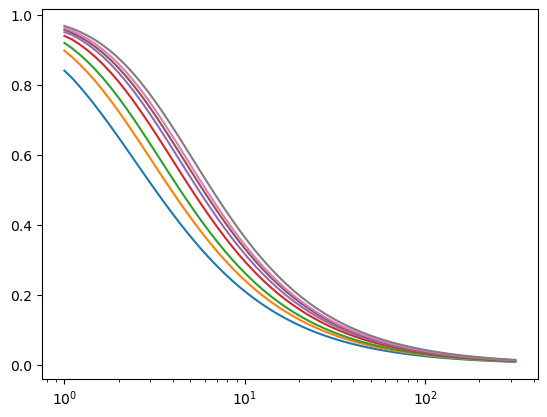

In [59]:
for j in range(len(ns)):
    plt.plot(mode_gaps,doctor_effectiveness[:,j])
plt.xscale('log')

In [25]:
optimal_x, optimal_y

(0.005079337564685613, 0.000914847877213217)

In [15]:
optimize_nd_many_perturbations(n=5, mode_gap = 100, sigma = 0.1, n_perturbs = 2000)

100%|███████████████████████| 100/100 [02:41<00:00,  1.61s/it]


(1.1071487177940904, 0.01118332038175849, 0.0)

In [208]:
mode_gaps = np.logspace(0,2.5,15)
sigmas = [0.01,1,5,10,50]
alphas_s = np.zeros((len(mode_gaps),len(sigmas)))
alphas_g = np.zeros((len(mode_gaps),len(sigmas)))
for i in range(len(mode_gaps)):
    for j in range(len(sigmas)):
        theta, alpha_s, alpha_g = optimize_nd_many_perturbations(n=5, mode_gap = mode_gaps[i], sigma = sigmas[j], n_perturbs = 2000)
        alphas_s[i,j] = alpha_s
        alphas_g[i,j] = alpha_g

100%|███████████████████████| 100/100 [03:08<00:00,  1.88s/it]


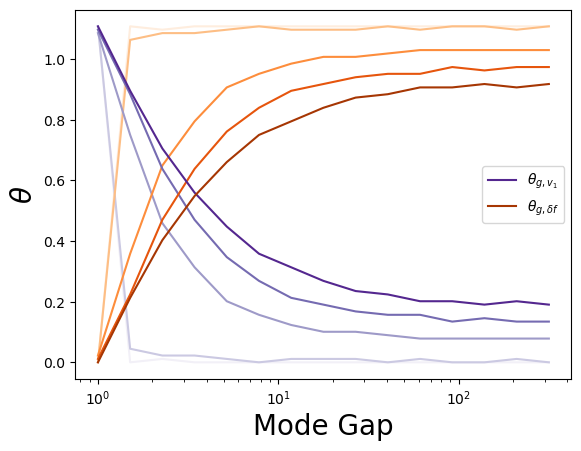

In [247]:
import palettable.colorbrewer.sequential as pal
from matplotlib.colors import ListedColormap

colors = [pal.Purples_5.mpl_colors[i] for i in range(len(sigmas))]
colors2 = [pal.Oranges_5.mpl_colors[i] for i in range(len(sigmas))]

cmap = ListedColormap(colors)

for i in range(len(sigmas)):
    labels =['_nolegend_','_nolegend_','_nolegend_','_nolegend_',r'$\theta_{g,v_1}$']

    plt.plot(mode_gaps,alphas_g[:,i],label = labels[i],color = colors[i])

    labels =['_nolegend_','_nolegend_','_nolegend_','_nolegend_',r'$\theta_{g,\delta f}$']
    plt.plot(mode_gaps,theta - alphas_g[:,i],color = colors2[i],label = labels[i])
plt.xscale('log')
plt.xlabel('Mode Gap', fontsize=20)
plt.ylabel(r'$\theta$', fontsize=20)

plt.legend()

In [207]:
mode_gaps = np.logspace(0,2.5,15)
mode_gaps

array([  1.        ,   1.50859071,   2.27584593,   3.43332002,
         5.17947468,   7.81370738,  11.78768635,  17.7827941 ,
        26.82695795,  40.47089951,  61.05402297,  92.10553177,
       138.94954944, 209.61799925, 316.22776602])

In [161]:
mode_gaps = np.logspace(0,5,15)
alphas_s = []
alphas_g = []
for mode_gap in tqdm(mode_gaps):
    theta, alpha_s, alpha_g = optimize_nd_single_perturbation(n=20,mode_gap = mode_gap)
    alphas_s.append(alpha_s)
    alphas_g.append(alpha_g)

100%|█████████████████████████| 15/15 [00:14<00:00,  1.00it/s]


In [142]:
mode_gaps[0]

1.0

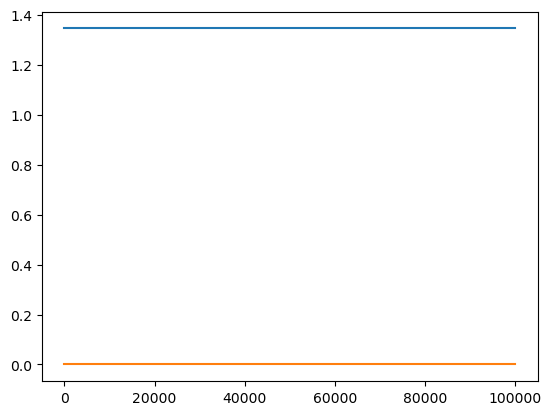

In [163]:
plt.plot(mode_gaps,alphas_s)
plt.plot(mode_gaps,theta-alphas_s)

In [146]:
np.cos(alphas_g)

array([0.4472136 , 0.59926345, 0.72451504, 0.81672578, 0.88135862,
       0.9243697 , 0.94786882, 0.96419652, 0.97509077, 0.97980753,
       0.98403413, 0.98776848, 0.98945047, 0.98945047, 0.99100871])

In [126]:
df = (np.zeros(n) + 1)/np.linalg.norm(np.zeros(n) + 1)
v_1 = np.zeros(n)
v_1[0] = 1
Jx = np.zeros((n,n))
for i in range(n):
    Jx[i,i] = -2
Jx[0,0]= -2/1000

s = np.cos(alphas_s[-1])*v_1 + np.cos(theta-alphas_s[-1])*df
g = np.cos(alphas_g[-1])*v_1 + np.cos(theta-alphas_g[-1])*df
gJxs = np.matmul(g,np.matmul(np.linalg.inv(Jx),s))
Jxgs_inv = np.linalg.inv(Jx - np.outer(g, s))
dx_norm_efficient(df,Jxgs_inv,gJxs)

0.3124743273526178

In [128]:
np.linalg.norm(s)

1.4149353510132465

In [53]:
n = 5
v_1 = np.zeros(n)
v_1[0] = 1
df = np.zeros(n) + 1
df = df/np.linalg.norm(df)
theta = np.arccos(np.dot(df,v_1))


2.8375525375210455

In [59]:
alphas_s = np.linspace(0,theta,100)
alphas_s

array([0.        , 0.01118332, 0.02236664, 0.03354996, 0.04473328,
       0.0559166 , 0.06709992, 0.07828324, 0.08946656, 0.10064988,
       0.1118332 , 0.12301652, 0.13419984, 0.14538316, 0.15656649,
       0.16774981, 0.17893313, 0.19011645, 0.20129977, 0.21248309,
       0.22366641, 0.23484973, 0.24603305, 0.25721637, 0.26839969,
       0.27958301, 0.29076633, 0.30194965, 0.31313297, 0.32431629,
       0.33549961, 0.34668293, 0.35786625, 0.36904957, 0.38023289,
       0.39141621, 0.40259953, 0.41378285, 0.42496617, 0.43614949,
       0.44733282, 0.45851614, 0.46969946, 0.48088278, 0.4920661 ,
       0.50324942, 0.51443274, 0.52561606, 0.53679938, 0.5479827 ,
       0.55916602, 0.57034934, 0.58153266, 0.59271598, 0.6038993 ,
       0.61508262, 0.62626594, 0.63744926, 0.64863258, 0.6598159 ,
       0.67099922, 0.68218254, 0.69336586, 0.70454918, 0.7157325 ,
       0.72691582, 0.73809915, 0.74928247, 0.76046579, 0.77164911,
       0.78283243, 0.79401575, 0.80519907, 0.81638239, 0.82756

In [96]:
Jx = np.zeros((n,n))
for i in range(n):
    Jx[i,i] = -2

100%|█████████████████████████████████| 10000/10000 [00:00<00:00, 25794.72it/s]


(-5.0, 5.0)

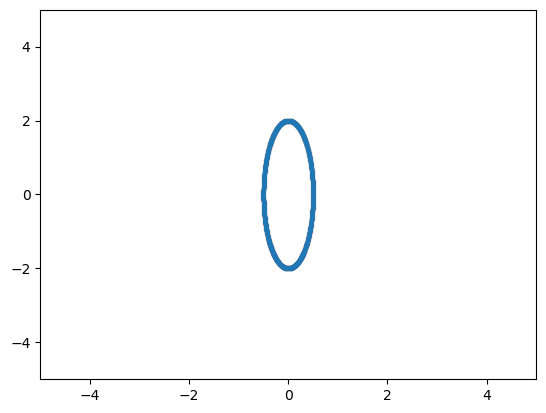

In [97]:
sigma = .1
Jx[1,1] = Jx[1,1]/4
dfs = generate_distributed_vectors(2,10000,sigma)
xs = []
ys = []
for df in tqdm(dfs):
    dx = np.matmul(np.linalg.inv(Jx), df)
    xs.append(dx[0])
    ys.append(dx[1])
plt.scatter(xs,ys,alpha = 0.01,marker = '.')
plt.ylim([-5,5])
plt.xlim([-5,5])

In [11]:
def avg_dx_norm_old(s,g, Jx):
    n = len(s)
    return np.mean([dx_norm(df,g,s, Jx) for df in generate_evenly_distributed_vectors(n,100)])

In [194]:
def avg_dx_norm(s,g, Jx,sigma):
    n = len(s)
    return np.mean([dx_norm(df,g,s, Jx) for df in generate_distributed_vectors(n,1000,sigma)])

In [55]:
def avg_dx_norm_single(s,g, Jx):
    n = len(s)
    df = np.zeros(n) + 1
    df = df/np.linalg.norm(df)
    return dx_norm(df,g,s, Jx)

In [33]:
bounds= []
for i in range(n-2):
    bounds.append([0,np.pi])
bounds.append([0,2*np.pi])
bounds = bounds + bounds
bounds

[[0, 6.283185307179586], [0, 6.283185307179586]]

In [36]:
def optimize_sg(Jx,sigma):
    n = Jx.shape[0]
    bounds = []
    for i in range(n-2):
        bounds.append([0,np.pi])
    bounds.append([0,2*np.pi])
    bounds = bounds + bounds
    print(n)
    initial_guess = np.zeros(2*(n-1))+np.pi/8
    # Minimize the negative dot product to maximize the dot product
    result = sp.optimize.basinhopping(
        lambda x: avg_dx_norm(map_angles_to_n_sphere(x[:(n-1)]), map_angles_to_n_sphere(x[(n-1):]),Jx,sigma),
        initial_guess,
        minimizer_kwargs={"bounds": bounds})

    optimized_s = map_angles_to_n_sphere(result.x[:(n-1)])
    optimized_g = map_angles_to_n_sphere(result.x[(n-1):])
    return optimized_s, optimized_g

In [247]:
def optimize_sg_alpha(Jx,sigma):
    n = Jx.shape[0]
    bounds = [[0,1],[0,1]]
    print(n)
    v_1 = np.zeros(n)
    v_1[0] = 1
    df = np.zeros(n) + 1
    df = df/np.linalg.norm(df)
    initial_guess = [0,0]
    # Minimize the negative dot product to maximize the dot product
    result = sp.optimize.minimize(
        lambda x: integrate_function_over_vmf(df,x[0]*v_1 + (1-x[0])*df, x[1]*v_1 + (1-x[1])*df,Jx,sigma),
        initial_guess,
        bounds = bounds)

    optimized_g = result.x[0]*v_1 + (1-result.x[0])*df
    optimized_s = result.x[1]*v_1 + (1-result.x[1])*df
    return optimized_s, optimized_g

In [217]:
v_1 = np.zeros(n)
v_1[0] = 1
df = np.zeros(n) + 1
df = df/np.linalg.norm(df)
i_s = []
j_s = []
norms = []
for i in tqdm(np.linspace(0,1,100)):
    for j in np.linspace(0,1,100):
        norms.append(avg_dx_norm(i*v_1 + (1-i)*df, j*v_1 + (1-j)*df,Jx,sigma))
        i_s.append(i)
        j_s.append(j)

100%|████████████████████████████████████████| 100/100 [12:07<00:00,  7.27s/it]


In [271]:
n = 5
Jx = np.zeros((n,n))
for i in range(n):
    Jx[i,i] = -2
Jx[0,0]= -0.02
s,g = optimize_sg_alpha(Jx,2)

5


In [270]:
s,g

(array([1., 0., 0., 0.]), array([1., 0., 0., 0.]))

In [256]:
def generate_pairs(array1, array2):
    n = len(array1)
    pairs = np.empty((2, n * n))
    
    for i in range(n):
        for j in range(n):
            pairs[0, i * n + j] = array1[i]
            pairs[1, i * n + j] = array2[j]
    
    return pairs

In [258]:
xs = generate_pairs(np.linspace(0,1,100), np.linspace(0,1,100))

In [261]:
xs.shape[1]

10000

In [263]:
n = 3
Jx = np.zeros((n,n))
for i in range(n):
    Jx[i,i] = -2
df = np.zeros(n) + 1
df = df/np.linalg.norm(df)
v_1 = np.zeros(n)
v_1[0] = 1
results = []
for i in tqdm(range(xs.shape[1])):
    x = xs[:,i]
    results.append(integrate_function_over_vmf(df,x[0]*v_1 + (1-x[0])*df, x[1]*v_1 + (1-x[1])*df,Jx,sigma))

  8%|██▊                                | 807/10000 [54:25<10:20:04,  4.05s/it]


KeyboardInterrupt: 

In [210]:
avg_dx_norm(s,g,Jx,sigma)

0.42961434282180994

In [201]:
df = np.zeros(n) + 1
df = df/np.linalg.norm(df)
df

array([0.70710678, 0.70710678])

In [252]:
s,g

(array([0.5, 0.5, 0.5, 0.5]),
 array([0.69180915, 0.30819085, 0.30819085, 0.30819085]))

In [56]:
def optimize_sg_old(Jx):
    n = Jx.shape[0]
    bounds = [[0,np.pi] for i in range(n-2)]
    bounds.append([0,2*np.pi])
    for i in range(n-2):
        bounds.append([0,np.pi])
    bounds.append([0,2*np.pi])
    print(n)
    initial_guess = np.zeros(2*(n-1))+np.pi/8
    # Minimize the negative dot product to maximize the dot product
    result = sp.optimize.basinhopping(
        lambda x: avg_dx_norm_single(map_angles_to_n_sphere(x[:(n-1)]), map_angles_to_n_sphere(x[(n-1):]),Jx),
        initial_guess,
        minimizer_kwargs={"bounds": bounds})

    optimized_s = map_angles_to_n_sphere(result.x[:(n-1)])
    optimized_g = map_angles_to_n_sphere(result.x[(n-1):])
    return optimized_s, optimized_g

In [100]:
def optimize_sg_constrained_4(Jx):
    n = 4
    bounds = [[0,2*np.pi] for i in range(2)]

    print(n)
    initial_guess = np.zeros(2)+np.pi/8
    # Minimize the negative dot product to maximize the dot product
    result = sp.optimize.basinhopping(
        lambda x: avg_dx_norm(map_angles_to_n_sphere([x[0],0,0]), map_angles_to_n_sphere([x[1],0,0]),Jx),
        initial_guess,
        minimizer_kwargs={"bounds": bounds})

    optimized_s = map_angles_to_n_sphere([result.x[0],0,0])
    optimized_g = map_angles_to_n_sphere([result.x[1],0,0])
    return avg_dx_norm(optimized_s, optimized_g,Jx)

In [167]:
n = 2
Jx = np.zeros((n,n))
for i in range(n):
    Jx[i,i] = -2
k = 200
s_attempts = generate_evenly_distributed_vectors(n,k)
g_attempts = generate_evenly_distributed_vectors(n,k)
sigma = 0.001
dx_norms = np.zeros((k,k))
for i in tqdm(range(k)):
    for j in range(k):
       dx_norms[i,j] = avg_dx_norm(s_attempts[i],g_attempts[j], Jx,sigma)

100%|████████████████████████████████████████| 200/200 [04:15<00:00,  1.28s/it]


In [168]:
i,j = np.where(dx_norms == np.min(dx_norms))
print(s_attempts[i[0]])
print(g_attempts[j[0]])

[-0.99104116 -0.13355683]
[-0.99836779 -0.05711187]


In [143]:

n = 4
Jx = np.zeros((n,n))
for i in range(n):
    Jx[i,i] = -2
mode_gaps = np.logspace(0, -8, num=50,  base=2)
gs = []
ss = []

for i in tqdm(range(1)):
    Jx[1,1] = mode_gaps[-i]*Jx[1,1]
    s,g = optimize_sg(Jx,4)
    gs.append(g)
    ss.append(s)

  0%|                                                    | 0/1 [00:00<?, ?it/s]

4


  0%|                                                    | 0/1 [01:57<?, ?it/s]


KeyboardInterrupt: 

In [142]:
mu = np.zeros(n) + 1
mu = mu/np.linalg.norm(mu)
avg_dx_norm(mu,mu,Jx,4)


0.37638339601438653

In [160]:
mu = np.zeros(n) + 1
mu = mu/np.linalg.norm(mu)
avg_dx_norm([0,1,0,0],[0,1,0,0],Jx,4)

0.4613442208939524

In [53]:
g_von = np.array(gs)
s_von = np.array(ss)

In [49]:
mode_gaps = [-2,-1,-.5,-.25,-.125,-.0625,-.03125,-.03125/2]
Jx[2,2] = mode_gaps[-1]
s,g = optimize_sg(Jx,10000)
gs.append(g)
ss.append(s)

4


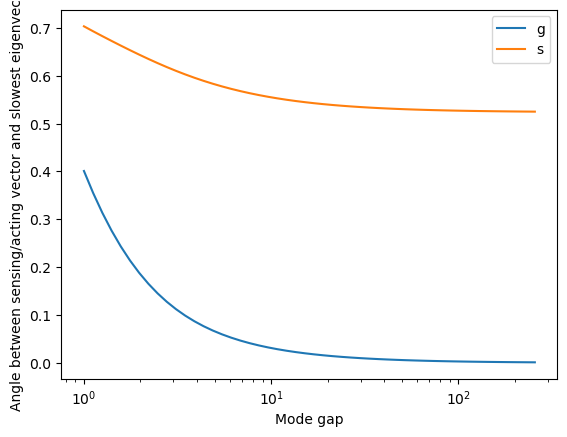

In [88]:
#mode_gaps = [-2,-1,-.5,-.25,-.125,-.0625,-.03125,-.03125/2]
mode_gaps = -np.logspace(0, -8, num=50,  base=2)
plt.plot(-1/(np.array(mode_gaps)), np.arccos(np.abs([np.dot(g,[0,1]) for g in gs])),label='g')
plt.plot(-1/(np.array(mode_gaps)), np.arccos(np.abs([np.dot(s,[0,1]) for s in ss])),label = 's')
plt.xscale('log')
plt.ylabel('Angle between sensing/acting vector and slowest eigenvector')
plt.xlabel('Mode gap')
plt.legend()

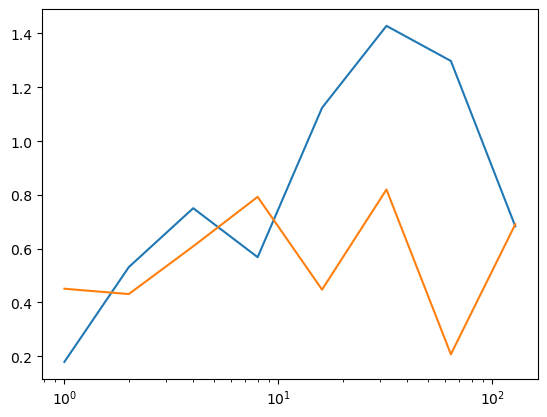

In [85]:
n = 4
mu = np.zeros(n) + 1
mu = mu/np.linalg.norm(mu)
plt.plot(1/(np.array(mode_gaps)/-2), np.arccos(np.abs([np.dot(g,mu) for g in g_von])))
plt.plot(1/(np.array(mode_gaps)/-2), np.arccos(np.abs([np.dot(s,mu) for s in s_von])))
plt.xscale('log')

In [67]:
gs[0]

array([0.35526836, 0.35526666, 0.78826085, 0.35526726])

In [40]:
n = 4
mu = np.zeros(n) + 1
mu = mu/np.linalg.norm(mu)
sigma = 100000
sp.stats.vonmises_fisher.rvs(mu=mu, kappa = sigma,size = 5)

array([[0.50027712, 0.50035241, 0.49790621, 0.50145755],
       [0.50197428, 0.50053101, 0.49938261, 0.49810394],
       [0.50203466, 0.49982103, 0.49865503, 0.49948303],
       [0.50037785, 0.49961032, 0.49634707, 0.50363788],
       [0.50079495, 0.49965677, 0.5016969 , 0.4978431 ]])

In [182]:
results = []
Jxs = []
for j in tqdm(range(30)):    
    n = 4
    D = np.zeros((n,n))
    for i in range(n):
        D[i,i] = -1

    D[1,1] = -0.001

    P = gram_schmidt(np.random.rand(4,4))
    Jx = np.matmul(np.matmul(P,D),np.linalg.inv(P))
    results.append(optimize_sg_constrained_4(Jx))
    Jxs.append(Jx)


  0%|                                                 | 0/30 [00:00<?, ?it/s]

4


  3%|█▎                                       | 1/30 [00:31<15:27, 32.00s/it]

4


  7%|██▋                                      | 2/30 [01:04<14:56, 32.02s/it]

4


 10%|████                                     | 3/30 [01:33<13:52, 30.84s/it]

4


 13%|█████▍                                   | 4/30 [02:06<13:46, 31.80s/it]

4


 17%|██████▊                                  | 5/30 [02:40<13:30, 32.42s/it]

4


 20%|████████▏                                | 6/30 [03:12<12:57, 32.40s/it]

4


 23%|█████████▌                               | 7/30 [03:44<12:18, 32.11s/it]

4


 27%|██████████▉                              | 8/30 [04:17<11:57, 32.62s/it]

4


 30%|████████████▎                            | 9/30 [04:53<11:44, 33.56s/it]

4


 33%|█████████████▎                          | 10/30 [05:25<10:59, 32.96s/it]

4


 37%|██████████████▋                         | 11/30 [05:59<10:37, 33.55s/it]

4


 40%|████████████████                        | 12/30 [06:33<10:01, 33.41s/it]

4


 43%|█████████████████▎                      | 13/30 [07:10<09:50, 34.74s/it]

4


 47%|██████████████████▋                     | 14/30 [07:43<09:03, 33.98s/it]

4


 50%|████████████████████                    | 15/30 [08:19<08:39, 34.63s/it]

4


 53%|█████████████████████▎                  | 16/30 [08:54<08:09, 34.96s/it]

4


 57%|██████████████████████▋                 | 17/30 [09:32<07:42, 35.59s/it]

4


 60%|████████████████████████                | 18/30 [10:01<06:46, 33.86s/it]

4


 63%|█████████████████████████▎              | 19/30 [10:37<06:17, 34.29s/it]

4


 67%|██████████████████████████▋             | 20/30 [11:11<05:42, 34.29s/it]

4


 70%|████████████████████████████            | 21/30 [11:46<05:09, 34.44s/it]

4


 73%|█████████████████████████████▎          | 22/30 [12:20<04:34, 34.27s/it]

4


 77%|██████████████████████████████▋         | 23/30 [12:58<04:07, 35.36s/it]

4


 80%|████████████████████████████████        | 24/30 [13:39<03:43, 37.27s/it]

4


 83%|█████████████████████████████████▎      | 25/30 [14:18<03:08, 37.66s/it]

4


 87%|██████████████████████████████████▋     | 26/30 [15:00<02:36, 39.10s/it]

4


 90%|████████████████████████████████████    | 27/30 [15:39<01:56, 38.96s/it]

4


 93%|█████████████████████████████████████▎  | 28/30 [16:16<01:16, 38.30s/it]

4


 97%|██████████████████████████████████████▋ | 29/30 [16:50<00:36, 36.97s/it]

4


100%|████████████████████████████████████████| 30/30 [17:29<00:00, 34.97s/it]


In [194]:
axis_frac = [np.sum([np.abs(Jxs[j][i,i]) for i in range(4)])/np.sum(np.abs(Jxs[j])) for j in range(len(Jxs))]

In [192]:
axis_frac = [np.abs(Jxs[j][1,1])/np.sum(np.abs(Jxs[j])) for j in range(len(Jxs))]

(0.0, 10.0)

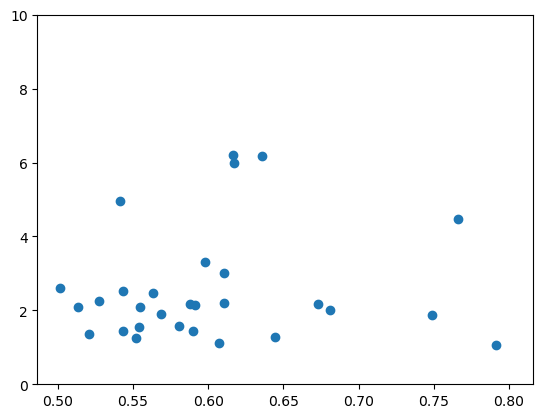

In [195]:
plt.scatter(axis_frac,results)
plt.ylim([0,10])

In [187]:
np.sum([np.abs(Jxs[j][i,i]) for i in range(4)])/np.sum(np.abs(Jxs[j]))

0.5434977395308782

In [176]:
np.round(P,2)

array([[ 0.38,  0.28,  0.76,  0.45],
       [ 0.9 , -0.32, -0.21, -0.21],
       [ 0.2 ,  0.91, -0.29, -0.24],
       [ 0.08,  0.03, -0.54,  0.84]])

In [76]:
def evs(a,b,c):
    return [map_angles_to_n_sphere([0+a,0+b,0+c]),
            map_angles_to_n_sphere([np.pi/2+a,np.pi/2+b,0+c]),
            map_angles_to_n_sphere([np.pi/2+a,0+b,0+c]),
            map_angles_to_n_sphere([np.pi/2+a,np.pi/2+b,np.pi/2+c])]

In [79]:
def hopf_coord(theta):
    return [np.cos(theta[0])*np.sin(theta[1]),
            np.sin(theta[0])*np.sin(theta[1]),
            np.cos(theta[2])*np.cos(theta[1]),
            np.sin(theta[2])*np.cos(theta[1])]


In [121]:
def evs(a,b,c):
    return [hopf_coord([0+a,np.pi/2,0+b]),
            hopf_coord([np.pi/2+a,np.pi/2,0+b]),
            hopf_coord([0+a,0,0+b]),
            hopf_coord([0+a,0,np.pi/2+b])]

In [132]:
a = .2
b = .2
c = .1
np.dot(evs(a,b,c)[0],evs(a,b,c)[1])


8.326672684688674e-17

In [98]:
P = np.stack(evs(.2,.4),axis = 1)
P[:,0]

array([9.80066578e-01, 1.98669331e-01, 5.63987199e-17, 2.38449963e-17])

In [99]:
evs(.2,.4)[0]

[0.9800665778412416,
 0.19866933079506122,
 5.639871990625564e-17,
 2.384499632187786e-17]

In [82]:
hopf_coord([0,np.pi/2,0])
hopf_coord([np.pi/2,np.pi/2,0])
hopf_coord([0,0,0])
hopf_coord([0,0,np.pi/2])

[1.0, 0.0, 6.123233995736766e-17, 0.0]
[6.123233995736766e-17, 1.0, 6.123233995736766e-17, 0.0]
[0.0, 0.0, 1.0, 0.0]
[0.0, 0.0, 6.123233995736766e-17, 1.0]


In [77]:
ev = evs(1,0,0)

In [75]:
np.dot(ev[2],ev[1])

0.7080734182735712

(array([  0.,   7.,   0., 266.,   0.,   0., 726.,   0.,   0.,   1.]),
 array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.]),
 <BarContainer object of 10 artists>)

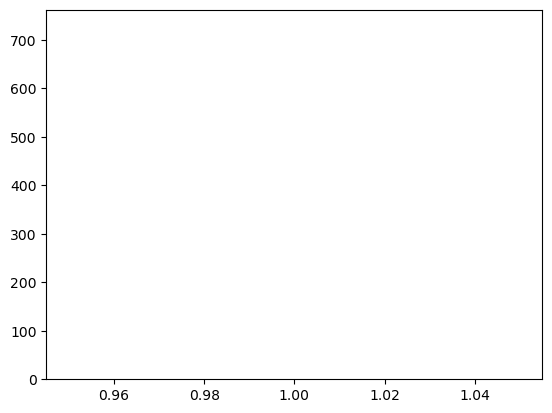

In [18]:
plt.hist([np.linalg.norm(map_angles_to_n_sphere(np.random.rand(4)*10)) for i in range(1000)])

In [40]:
avg_dx_norm(map_angles_to_n_sphere(np.random.rand(n-1)),map_angles_to_n_sphere(np.random.rand(n-1)),Jx)

5.6339043248944245

In [15]:
bounds = [[0,np.pi] for i in range(n-2)]
bounds.append([0,2*np.pi])
for i in range(n-2):
    bounds.append([0,np.pi])
bounds.append([0,2*np.pi])

bounds

[[0, 3.141592653589793],
 [0, 3.141592653589793],
 [0, 3.141592653589793],
 [0, 3.141592653589793],
 [0, 3.141592653589793],
 [0, 3.141592653589793],
 [0, 3.141592653589793],
 [0, 3.141592653589793],
 [0, 6.283185307179586],
 [0, 3.141592653589793],
 [0, 3.141592653589793],
 [0, 3.141592653589793],
 [0, 3.141592653589793],
 [0, 3.141592653589793],
 [0, 3.141592653589793],
 [0, 3.141592653589793],
 [0, 3.141592653589793],
 [0, 6.283185307179586]]

In [146]:
def gram_schmidt(vectors):
    num_vectors, vector_dim = vectors.shape
    orthogonalized_vectors = np.zeros((num_vectors, vector_dim))

    for i in range(num_vectors):
        v = vectors[i]
        for j in range(i):
            u = orthogonalized_vectors[j]
            v = v - np.dot(v, u) / np.dot(u, u) * u
        orthogonalized_vectors[i] = v / np.linalg.norm(v)

    return orthogonalized_vectors


In [156]:
P = gram_schmidt(np.random.rand(4,4))
np.dot(P[0,:],P[0,:])

1.0000000000000002

In [158]:
np.linalg.norm(P[0,:])

1.0